In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.autonotebook import tqdm
import skimage
import glob
import captum
import latentshift
import ct_counterfactuals as ct_cf

/tmp/ipykernel_36675/4168746775.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
device = 'cuda'

In [4]:
model = ct_cf.classifiers.phecode.PheCodeClassifier().to(device)

In [5]:
ae = ct_cf.ae.VQGAN(
    weights='2023-12-25T10-26-40_ct2_vqgan256_sddd',
    download=False,
    cache_dir='/home/users/joecohen/scratch/cache/'
).to(device)

Working with z of shape (1, 256, 4, 4) = 4096 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [6]:
data = ct_cf.datasets.NIFTI_Dataset('volumes/', resolution=224)

In [7]:
len(data)

1

In [8]:
img = data[0]['image'][None,...]
img.shape

torch.Size([1, 1, 224, 224, 134])

In [9]:
img.min(), img.max()

(metatensor(0.), metatensor(1.))

In [10]:
for i in range(1):
    sample = data[i]
    img = sample['image'][None,...]
    with torch.no_grad():
        o = model(img.cuda()).cpu()
    print(i, os.path.basename(sample['image_path']))

    for ind, target in [(i, target) for i, target in enumerate(model.targets) if 'effusion' in target.lower()]:
        print("   " + str(float(o[:,ind])) + "  " + model.targets[ind])

0 TCIA-LCTSC-_RCCTPET_THORAX_CONTRAST_dag0_20080918110916_4268307088.nii.gz
   0.04917047917842865  Pleurisy; pleural effusion
   0.012950110249221325  Joint effusions


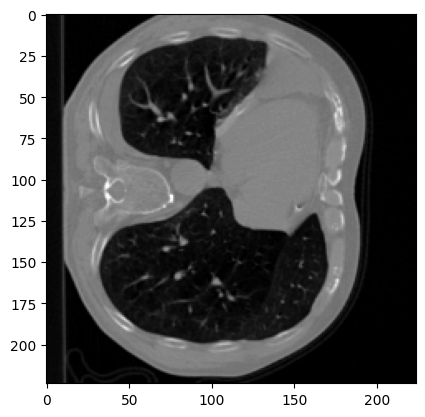

In [11]:
plt.imshow(img[0,0,:,:,50], cmap='gray');

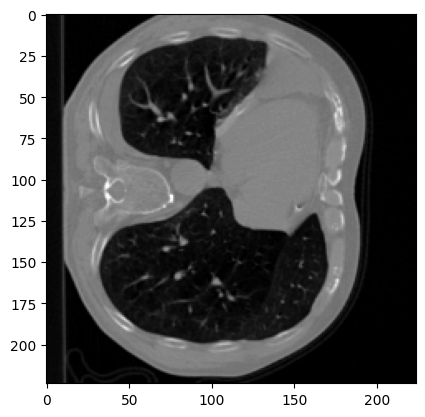

In [12]:
x = img[:,:,:,:,50]
plt.imshow(x[0][0].cpu().detach().numpy(), cmap='gray');

In [13]:
z = ae.encode(x.cuda())

In [14]:
img2 = ae.decode(z)

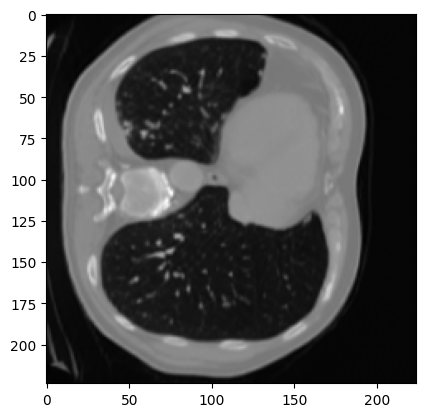

In [15]:
plt.imshow(img2[0][0].cpu().detach().numpy(), cmap='gray');

In [16]:
attr = captum.attr.LatentShift(
    latentshift.alignment.ModelWrapper(
        model, 
        target='Pleurisy; pleural effusion', 
        adjustment=lambda x: x+0.4,
        rename_model='', sigmoid=False), 
    ct_cf.ae.SliceAEFull(ae, 45,55),
)
output = attr.attribute(img.cuda(), target=0,
                        return_dicts = True,
                        apply_sigmoid = False,
                        search_max_steps = 20000,
                       )[0]

Shift: 0, Pred: 0.4126940071582794, pixel_diff: 0.0, sum*diff_pct: 130881.390625
Shift: -10.0, Pred: 0.4125969111919403, pixel_diff: 4.4695587158203125, sum*diff_pct: 130881.390625
Shift: -21.0, Pred: 0.41249391436576843, pixel_diff: 9.383288383483887, sum*diff_pct: 130881.390625
Shift: -34.0, Pred: 0.41237786412239075, pixel_diff: 15.18867301940918, sum*diff_pct: 130881.390625
Shift: -48.0, Pred: 0.41225525736808777, pixel_diff: 21.45244789123535, sum*diff_pct: 130881.390625
Shift: -63.0, Pred: 0.4121263027191162, pixel_diff: 28.156644821166992, sum*diff_pct: 130881.390625
Shift: -80.0, Pred: 0.41198644042015076, pixel_diff: 35.76353454589844, sum*diff_pct: 130881.390625
Shift: -98.0, Pred: 0.4118422269821167, pixel_diff: 43.81715774536133, sum*diff_pct: 130881.390625
Shift: -118.0, Pred: 0.41168665885925293, pixel_diff: 52.76280212402344, sum*diff_pct: 130881.390625
Shift: -140.0, Pred: 0.4115247130393982, pixel_diff: 62.60514831542969, sum*diff_pct: 130881.390625
Shift: -164.0, Pred

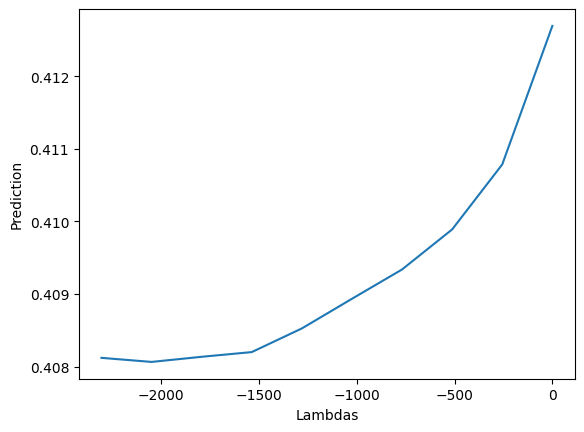

In [17]:
plt.plot(output['lambdas'],output['preds']);
plt.xlabel('Lambdas');
plt.ylabel('Prediction');

In [18]:
single_diffs = np.abs(output['heatmap']).sum(0).sum(0).sum(0)

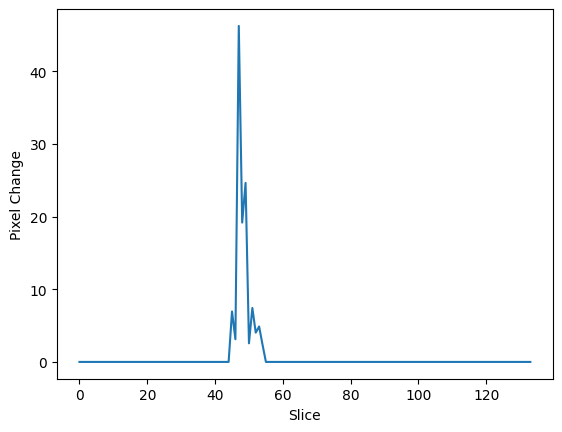

In [19]:
plt.plot(single_diffs);
plt.xlabel('Slice');
plt.ylabel('Pixel Change');

In [20]:
output['heatmap'].shape

(1, 224, 224, 134)

In [21]:
idx = output['heatmap'].sum(1).sum(1).argmax()
idx

47

In [22]:
idx =47

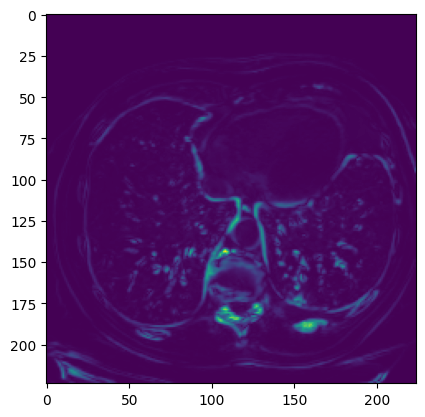

In [23]:
plt.imshow(skimage.transform.rotate(output['heatmap'][0,:,::-1,idx], -90));

In [24]:
images = [output['generated_images'][i, :,::-1,:,idx] for i in range(len(output['generated_images']))]
images = [skimage.transform.rotate(img[0],90)[None,...] for img in images]


In [25]:
images = [ct_cf.datasets.window_level(img, -1000, 100) for img in images]

0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125


In [26]:
images[0].shape

(1, 224, 224)

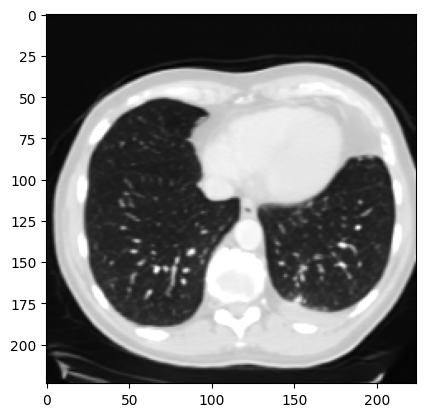

In [27]:
plt.imshow(images[-1][0], cmap='gray');

In [28]:
latentshift.video_utils.generate_video({'generated_images':images, 'preds':np.array(output['preds'])-(np.array(output['preds']).min())}, "effusion", show_pred=True, watermark=False, cmap='gray', 
                                       extra_loops=3,
                                      ffmpeg_path='/share/software/user/open/ffmpeg/5.0/bin/ffmpeg',
                                      resize=512)


/share/software/user/open/ffmpeg/5.0/bin/ffmpeg -loglevel quiet -stats -y -i /tmp/gifsplanation/image-%d.png -c:v libx264 -vf scale=-2:512 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'effusion.mp4'


b''


frame=  160 fps= 65 q=28.0 Lsize=     239kB time=00:00:06.36 bitrate= 308.4kbits/s speed=2.58x    


In [29]:
latentshift.video_utils.write_frame(images[-1][0], 'effusion-base.png', cmap='gray', watermark=False)

In [30]:
latentshift.video_utils.write_frame(images[0][0], 'effusion-cf.png', cmap='gray', watermark=False)